In [1]:
!pip install -q stanza
!pip install -q wordfreq
!pip install -q seaborn matplotlib


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import stanza
stanza.download("en")
import csv
import re
import logging
from typing import List, Dict, Any, Optional
from pathlib import Path
from scipy.stats import kruskal
from wordfreq import zipf_frequency
from IPython.display import display

from google.colab import drive
drive.mount('/content/drive')

INFO:stanza:Downloaded file to /root/stanza_resources/resources.json
INFO:stanza:Downloading default packages for language: en (English) ...
INFO:stanza:File exists: /root/stanza_resources/en/default.zip
INFO:stanza:Finished downloading models and saved to /root/stanza_resources


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
class BulwerLyttonAnalyzer:
    """Complete text analysis pipeline for Bulwer-Lytton contest data"""

    def __init__(self, data_path: str | Path, *, gpu: bool = False):
        """Initialize analyzer with data path and NLP pipeline"""
        logging.basicConfig(level=logging.INFO)
        self.logger = logging.getLogger(__name__)
        self.data_path = data_path
        self.gpu = gpu

        # Regex patterns for simile detection
        self._simile_patterns = [
            re.compile(r'(?<!\w)[Aa]s\s+(?:\w+[\w\-]*\s+){0,5}?[Aa]s\s+(?:a|an|the)?\s?\w+[\w\-]*(?=\W|$)', re.IGNORECASE),
            re.compile(r'\b(?:is|are|was|were|looks?|feels?|seems?|sounds?)\s+[Ll]ike\s+(?:a|an|the)?\s?(?:\w+[\w\-]*\s*){1,5}(?=\W|$)', re.IGNORECASE),
            re.compile(r'\b[Ss]imilar\s+to\s+(?:a|an|the)?\s?(?:\w+[\w\-]*\s*){1,5}(?=\W|$)', re.IGNORECASE),
            re.compile(r'\b[Mm]ore\s+(?:\w+[\w\-]*\s+){1,4}?[Tt]han\s+(?:a|an|the)?\s?\w+[\w\-]*(?=\W|$)', re.IGNORECASE),
            re.compile(r'\b[Rr]esembles?\s+(?:a|an|the)?\s?(?:\w+[\w\-]*\s*){1,5}(?=\W|$)', re.IGNORECASE),
            re.compile(r'\b[Aa]s\s+(?:if|though)\s+(?:\w+[\w\-]*\s*){1,7}(?=\W|$)', re.IGNORECASE)
            ]

        # Feature definitions
        self._FEATURE_KEYS = [
            # syntactic
            "tree_depth", "dep_distance", "clause_ratio",
            "conj_count", "avg_sent_len",
            # lexical
            "ttr", "rare_ratio", "ner_density", "pos_diversity",
            # rhetoric
            "simile_density", "adj_count"
        ]

        # Load data and initialize NLP
        self.df = self._load_data()
        self.nlp = self._init_nlp()

    # ======================
    # Core Methods
    # ======================

    def _load_data(self) -> pd.DataFrame:
        """Load and preprocess raw data"""
        try:
            df = pd.read_csv(
                self.data_path,
                sep="\t",
                quoting=csv.QUOTE_NONE,
                on_bad_lines="skip",
                keep_default_na=False
            )

            # Standardize columns
            expected_cols = ["year", "text", "genre", "author", "location", "winning"]
            df.columns = expected_cols[:len(df.columns)]

            # Clean data
            df["genre"] = df["genre"].fillna("General").str.strip().str.title()
            df["text"] = df["text"].astype(str)
            df["year"] = pd.to_numeric(df["year"], errors="coerce")
            # Normalize genre labels
            genre_corrections = {
                "Vile Pun": "Vile Puns",
                "Historical'": "Historical Fiction",
                "Fantasy" : "Fantasy Fiction",
                "Vile Puns": "Vile Puns",
                "Sword And Sorcery": "Sword & Sorcery",
                "Dark And Stormy Night": "Dark & Stormy",
                "Dark & Stormy": "Dark & Stormy",
                "Dark And Stormy": "Dark & Stormy",
                "Plays-On-Dark-And-Stormy": "Dark & Stormy",
                "Detective": "Crime & Detective",
                "Children'S Literature": "Children's Literature",
                "Children'S & Young Adult Literature": "Children's Literature",
                "Children’S Literature": "Children's Literature",
                "Miscellaneous": "Misc",
                "Spy": "Spy Fiction",
                "All Creatures Great And Small": "All Creatures"
            }
            df["genre"] = df["genre"].replace(genre_corrections)

            self.logger.info(f"Loaded data with shape: {df.shape}")
            return df

        except Exception as e:
            self.logger.error(f"Data loading failed: {e}")
            raise

    def _init_nlp(self) -> stanza.Pipeline:
        """Initialize Stanza NLP pipeline"""
        return stanza.Pipeline(
            lang="en",
            processors="tokenize,pos,lemma,depparse,ner",
            use_gpu=self.gpu,
            tokenize_pretokenized=False,
            verbose=False,
            download_method=None
        )

    # ======================
    # Feature Extraction
    # ======================

    def analyze_texts(self, sample_size: Optional[int] = None) -> None:
        """Main analysis pipeline"""
        if sample_size:
            self.df = self.df.sample(min(sample_size, len(self.df)), random_state=42)

        self._validate_similes()
        self._extract_features()
        self._save_analysis_results()

    def _validate_similes(self) -> None:
        """Verify simile detection accuracy"""
        samples = self.df.sample(5, random_state=42)["text"].tolist()
        self.logger.info("Validating simile detection:")
        for text in samples:
            matches = [p.search(text) for p in self._simile_patterns if p.search(text)]
            status = "✅" if matches else "❌"
            print(f"{status} Sample: {text[:60]}...")

    def _extract_features(self) -> None:
        """Extract all linguistic features"""
        features = []
        for idx, row in self.df.iterrows():
            if idx % 100 == 0:
                self.logger.info(f"Processing text {idx}/{len(self.df)}")

            feats = self._extract_text_features(row)
            features.append(feats)

        features_df = pd.DataFrame(features)
        self.df = pd.concat([self.df, features_df], axis=1)

    def _extract_text_features(self, row: pd.Series) -> Dict[str, float]:
        """Extract features for single text"""
        text = str(row.get("text", "")).strip()
        if not text:
            return self._create_zero_features()

        try:
            doc = self.nlp(text)
            tokens = [w.text for s in doc.sentences for w in s.words]
            if not tokens:
                return self._create_zero_features()

            return {
                **self._extract_syntax_features(doc, len(tokens)),
                **self._extract_lexical_features(doc, tokens),
                **self._extract_rhetoric_features(text, doc, len(tokens))
            }
        except Exception as e:
            self.logger.warning(f"Feature extraction failed for text: {e}")
            return self._create_zero_features()

    def _create_zero_features(self) -> Dict[str, float]:
        """Return dictionary with all features set to 0"""
        return {k: 0.0 for k in self._FEATURE_KEYS}

    # ======================
    # Feature Calculation
    # ======================

    @staticmethod
    def _tree_depth(sentence: stanza.models.common.doc.Sentence) -> int:
        """Calculate maximum dependency tree depth"""
        parents = {word.id: word.head for word in sentence.words}
        max_depth = 0
        for wid in parents:
            d = 0
            while wid != 0:
                wid = parents[wid]
                d += 1
            max_depth = max(max_depth, d)
        return max_depth

    @staticmethod
    def _dependency_distance(sentence: stanza.models.common.doc.Sentence) -> float:
        """Calculate mean dependency distance"""
        dists = [abs(w.id - w.head) for w in sentence.words if w.head != 0]
        return sum(dists) / len(dists) if dists else 0.0

    def _extract_syntax_features(self, doc: stanza.Document, n_tokens: int) -> Dict[str, float]:
        """Extract syntactic complexity features"""
        if not doc.sentences:
            return {
                "tree_depth": 0.0,
                "dep_distance": 0.0,
                "clause_ratio": 0.0,
                "conj_count": 0.0,
                "avg_sent_len": 0.0
            }

        depths, dists, lengths = [], [], []
        clauses, conjunctions, relations = 0, 0, 0

        for sent in doc.sentences:
            depths.append(self._tree_depth(sent))
            dists.append(self._dependency_distance(sent))
            lengths.append(len(sent.words))

            for word in sent.words:
                clauses += word.deprel in {"acl", "advcl", "relcl"}
                conjunctions += word.deprel == "conj"
                relations += 1

        return {
            "tree_depth": max(depths),
            "dep_distance": sum(dists) / len(dists),
            "clause_ratio": clauses / relations if relations else 0.0,
            "conj_count": conjunctions,
            "avg_sent_len": sum(lengths) / len(lengths)
        }

    def _extract_lexical_features(self, doc: stanza.Document, tokens: List[str]) -> Dict[str, float]:
        """Extract lexical diversity features"""
        if not tokens:
            return {
                "ttr": 0.0,
                "rare_ratio": 0.0,
                "ner_density": 0.0,
                "pos_diversity": 0.0
            }

        pos_tags = [w.upos for s in doc.sentences for w in s.words]
        return {
            "ttr": len(set(tokens)) / len(tokens),
            "rare_ratio": sum(zipf_frequency(w, "en") < 3.0 for w in tokens) / len(tokens),
            "ner_density": len(doc.ents) / len(tokens),
            "pos_diversity": len(set(pos_tags)) / len(pos_tags) if pos_tags else 0.0
        }

    def _has_simile_with_noun(self, doc: stanza.Document, pattern) -> bool:
        """
        Enhanced simile matcher with POS validation.
        Detects:
            - like + (DET)? + (ADJ)* + NOUN
            - as ... as + (DET)? + (ADJ)* + NOUN
            - similar to / resembles / more than + NOUN
        """
        for sent in doc.sentences:
            # Match only if the pattern exists in sentence text
            if not pattern.search(sent.text):
                continue

            words = sent.words
            num_words = len(words)

            for i, word in enumerate(words):
                w_lower = word.text.lower()

                # ===== Case 1: "like" followed by NOUN/PROPN possibly with DET/ADJ =====
                if w_lower == "like" and i + 1 < num_words:
                    for j in range(1, 4):  # Check next 1-3 words
                        if i + j >= num_words:
                            break
                        pos_seq = [w.upos for w in words[i+1:i+j+1]]
                        # Allow: (DET)? (ADJ)* NOUN
                        if pos_seq and pos_seq[-1] in {"NOUN", "PROPN"}:
                            return True

                # ===== Case 2: "as ... as" with final noun =====
                elif w_lower == "as":
                    for j in range(i+1, min(i+6, num_words)):
                        if words[j].text.lower() == "as" and j + 1 < num_words:
                            # check if next word is NOUN or has (DET)?(ADJ)*NOUN
                           for k in range(1, 4):
                                if j + k >= num_words:
                                    break
                                pos_seq = [w.upos for w in words[j+1:j+k+1]]
                                if pos_seq and pos_seq[-1] in {"NOUN", "PROPN"}:
                                    return True

                # ===== Case 3: similar to / resembles / more than =====
                elif w_lower in {"similar", "resembles", "more"} and i + 1 < num_words:
                    for j in range(1, 5):
                        if i + j >= num_words:
                            break
                        pos_seq = [w.upos for w in words[i+1:i+j+1]]
                        if pos_seq and pos_seq[-1] in {"NOUN", "PROPN"}:
                            return True

        return False

    def _extract_rhetoric_features(self, text: str, doc: stanza.Document, n_tokens: int) -> Dict[str, float]:
        """Extract rhetorical features with POS-verified simile detection"""
        simile_count = 0
        simile_count = 0
        for pattern in self._simile_patterns:
          if self._has_simile_with_noun(doc, pattern):
            simile_count += 1

        return {
                "simile_density": simile_count / n_tokens if n_tokens else 0.0,
                "adj_count": sum(1 for w in doc.iter_words() if getattr(w, "xpos", "").startswith("JJ"))
          }

    # ======================
    # Visualization
    # ======================

    def plot_distributions(self) -> None:
        """Plot genre and year distributions"""
        df = self._prepare_plotting_data()
        df = analyzer.df.copy()
        df['genre'] = df['genre'].str.strip().str.title()
        df['year'] = pd.to_numeric(df['year'], errors='coerce')
        df = df.dropna(subset=['genre', 'year'])
        df['year'] = df['year'].astype(int)
        genre_year_count = df.groupby(['genre', 'year']).size().unstack(fill_value=0)
        print("🔢 Text Count Table (Genre × Year):")
        display(genre_year_count.head())

        # Genre-Year Heatmap
        genre_year = df.groupby(['genre', 'year']).size().unstack(fill_value=0)
        plt.figure(figsize=(14, 8))
        sns.heatmap(genre_year, cmap="YlGnBu", annot=True, fmt="d")
        plt.title("Texts per Genre and Year")
        plt.tight_layout()
        plt.show()

        # Yearly Distribution
        plt.figure(figsize=(12, 4))
        ax = sns.countplot(data=df, x='year', palette='Blues_d')
        plt.title("Texts per Year")
        plt.xticks(rotation=45)
        for container in ax.containers:
            ax.bar_label(container, label_type='edge', fontsize=8, padding=2)

        plt.tight_layout()
        plt.show()

        # Genre Distribution
        plt.figure(figsize=(12, 14))
        genre_order = df['genre'].value_counts().index
        ax = sns.countplot(data=df, y='genre', order=genre_order, palette='Set3')
        ax.set_title("Distribution of Entries per Genre in the Bulwer-Lytton Corpus", fontsize=14)
        ax.set_xlabel("Number of Entries")
        ax.set_ylabel("Genre")
        plt.tight_layout()
        plt.show()

    def visualize_features(self) -> None:
        """Visualize all feature types with consistent styling"""
        import numpy as np
        from matplotlib.lines import Line2D
        import matplotlib
        import seaborn as sns

        # plt.style.use('seaborn')
        sns.set_palette("husl")

        # --- SYNTAX FEATURES ---
        syntax_cols = ['tree_depth', 'dep_distance', 'clause_ratio']
        syntax_data = self.df.groupby('genre')[syntax_cols].mean()
        syntax_std = self.df.groupby('genre')[syntax_cols].std()
        normalized = (syntax_data - syntax_data.min()) / (syntax_data.max() - syntax_data.min())
        fig, ax = plt.subplots(figsize=(12, 8))
        sns.heatmap(normalized, annot=syntax_data.round(2), fmt=".2f",
                   cmap="YlGnBu", cbar_kws={'label': 'Normalized Value'},
                   linewidths=0.5, linecolor='white', ax=ax)

        if syntax_data.empty or syntax_data.isnull().all().all():
            print("⚠️ No syntactic feature data available for visualization.")
            return

        normalized = (syntax_data - syntax_data.min()) / (syntax_data.max() - syntax_data.min())

        fig, ax = plt.subplots(figsize=(14, len(syntax_data) * 0.4))
        sns.heatmap(normalized, annot=syntax_data.round(2), fmt=".2f",
              cmap="YlGnBu", cbar_kws={'label': 'Normalized Value'},
              linewidths=0.5, linecolor='white', ax=ax)

        # Add standard deviation bubbles
        for i, genre in enumerate(syntax_data.index):
            for j, metric in enumerate(syntax_data.columns):
                std_val = syntax_std.loc[genre, metric]
                ax.text(j + 0.9, i + 0.9, f"±{std_val:.2f}", color='red',
                        ha='right', va='bottom', fontsize=6)


        ax.set_title('Syntactic Complexity by Genre\n(Heatmap = Mean, Red Text = Std Dev)', pad=20)
        ax.set_xlabel('Syntactic Features')
        ax.set_ylabel('Genre')
        plt.tight_layout()
        plt.show()

        # Add legend for bubbles
        legend_elements = [
            Line2D([0], [0], marker='o', color='w', label='Standard Deviation',
                  markerfacecolor='red', markersize=10, alpha=0.5)]
        ax.legend(handles=legend_elements, loc='upper right')
        plt.tight_layout()
        plt.show()

        # --- LEXICAL FEATURES ---
        lexical_cols = ['ttr', 'rare_ratio', 'ner_density', 'pos_diversity', 'adj_count']
        lexical_data = self.df.groupby('genre')[lexical_cols].mean()
        lexical_norm = (lexical_data - lexical_data.min()) / (lexical_data.max() - lexical_data.min())

        fig, ax = plt.subplots(figsize=(max(16, len(lexical_data)*0.5), 10))
        bar_width = 0.08
        x = np.arange(len(lexical_cols))
        genres = list(lexical_data.index)
        # Set colors
        import matplotlib.colors as mcolors
        n = len(genres)
        cmap = plt.get_cmap('tab20b')
        colors = [cmap(i / n) for i in range(n)]
        genre_colors = dict(zip(genres, colors))

        for i, (genre, row) in enumerate(lexical_norm.iterrows()):
            bar_positions = x + i * bar_width
            ax.bar(bar_positions, row.values,
                   width=bar_width, label=genre,
                   color=genre_colors[genre])

            for j, val in enumerate(row.values):
                ax.text(bar_positions[j], val + 0.02,
                        f"{lexical_data.loc[genre].iloc[j]:.2f}",
                        ha='center', va='bottom', fontsize=6, rotation=90)

        ax.set_ylim(0, 1.1)
        ax.set_xticks(x + bar_width * (len(lexical_data) / 2 - 0.5))
        ax.set_xticklabels(lexical_cols, rotation=45)
        ax.set_ylabel('Normalized Score (0-1)')
        ax.set_title('Lexical Creativity Metrics by Genre\n(Normalized Means with Raw Values)')
        ax.legend(title='Genre', bbox_to_anchor=(1.02, 1), loc='upper left')
        ax.grid(axis='y', linestyle='--', alpha=0.5)
        plt.tight_layout()
        plt.show()

        # --- RHETORIC FEATURES ---
        rhetoric_cols = ['simile_density', 'adj_count', 'conj_count']
        rhetoric_data = self.df.groupby('genre')[rhetoric_cols].mean()
        rhetoric_norm = (rhetoric_data - rhetoric_data.min()) / (rhetoric_data.max() - rhetoric_data.min())

        fig, ax = plt.subplots(figsize=(12, 7))
        sns.heatmap(rhetoric_norm, annot=True, fmt=".2f", cmap="YlGnBu",
                   linewidths=0.5, cbar_kws={'label': 'Normalized Score (0-1)'}, ax=ax)
        ax.set_title("Rhetorical Feature Comparison Across Genres (Normalized)")
        ax.set_xlabel("Rhetorical Feature")
        ax.set_ylabel("Genre")
        plt.xticks(rotation=45, ha="right")
        plt.tight_layout()
        plt.show()

    # ======================
    # Statistical Analysis
    # ======================

    def run_statistical_tests(self) -> pd.DataFrame:
        """Run significance tests across genres"""
        results = []
        for feature in self._FEATURE_KEYS:
            groups = [
                g[feature].dropna()
                for _, g in self.df.groupby("genre")
                if not g[feature].isna().all()
            ]
            if len(groups) > 1:
                stat, p = kruskal(*groups)
                results.append({
                    "feature": feature,
                    "statistic": stat,
                    "p_value": p,
                    "significant": p < 0.05
                })

        return pd.DataFrame(results).sort_values("p_value")

    def _prepare_plotting_data(self) -> pd.DataFrame:
        """Prepare cleaned data for plotting"""
        df = self.df.copy()
        df['genre'] = df['genre'].str.strip().str.title()
        df['year'] = pd.to_numeric(df['year'], errors='coerce')
        return df.dropna(subset=['genre', 'year'])

    def _save_analysis_results(self) -> None:
        """Save analysis results to files"""
        self.df.to_csv("texts_with_features.csv", index=False)
        self.logger.info("Saved analysis results to CSV")


In [2]:
# ======================
# Main Execution
# ======================
if __name__ == "__main__":
    # initial
    analyzer = BulwerLyttonAnalyzer("/content/drive/MyDrive/stanza_humor_analysis/BL_HumorText.tsv", gpu=True)

    # 1. data
    analyzer.df = analyzer._load_data()

    # 2. distribution
    analyzer.plot_distributions()

    # 3. feature
    analyzer._extract_features()

    # 4. visualize features
    analyzer.visualize_features()

    # 5. Kruskal-Wallis
    test_results = analyzer.run_statistical_tests()
    display(test_results)

    #6. Mean/Std by Genre
    feature_cols = [
        "tree_depth", "dep_distance", "clause_ratio", "conj_count", "avg_sent_len",
        "ttr", "rare_ratio", "ner_density", "pos_diversity", "simile_density", "adj_count"
    ]
    genre_stats = analyzer.df.groupby("genre")[feature_cols].agg(['mean', 'std'])
    print(f"\n📊 Kruskal-Wallis H (tree_depth): H={test_results[test_results.feature == 'tree_depth'].statistic.values[0]:.2f}, "
          f"p={test_results[test_results.feature == 'tree_depth'].p_value.values[0]:.2e}\n")
    display(genre_stats)

     # 7. Temporal Analysis (4-year groups)
    import numpy as np
    df = analyzer.df.copy()
    df['year'] = pd.to_numeric(df['year'], errors='coerce')
    df = df.dropna(subset=['year'])
    df['year'] = df['year'].astype(int)
    bins = list(range(1982, 2026, 4))
    labels = [f"{y}-{y+3}" for y in bins[:-1]]
    df['year_group'] = pd.cut(df['year'], bins=bins, labels=labels, right=False)
    temporal_features = ['rare_ratio', 'simile_density', 'avg_sent_len']
    temporal_stats = df.groupby("year_group")[temporal_features].agg(['mean', 'std'])

    from scipy.stats import kruskal
    for feature in temporal_features:
      groups = [g[feature].dropna() for _, g in df.groupby("year_group") if not g[feature].isna().all()]
      if len(groups) > 1:
          stat, p = kruskal(*groups)
          print(f"📉 Temporal test for {feature}: H={stat:.2f}, p={p:.2e}")

    for feature in temporal_features:
        mean_df = df.groupby('year_group')[feature].mean().reset_index()
        mean_pivot = mean_df.pivot_table(index='year_group', values=feature)

        # 🔹 Heatmap
        plt.figure(figsize=(8, 4))
        sns.heatmap(mean_pivot, annot=True, fmt=".3f", cmap="YlOrRd", cbar_kws={'label': f'Mean {feature}'})
        plt.title(f"Heatmap of {feature} by Year Group")
        plt.ylabel("Year Group")
        plt.tight_layout()
        plt.show()

        # 🔹 Barplot
        plt.figure(figsize=(10, 5))
        sns.barplot(data=mean_df, x="year_group", y=feature, palette="Blues_d")
        plt.title(f"Barplot of {feature} over Time (4-Year Groups)")
        plt.xticks(rotation=45)
        plt.ylabel(feature)
        plt.tight_layout()
        plt.show()

    # 8. Genre-Year FacetGrid Temporal Trend Lineplots

    # Prepare Data
    df = analyzer.df.copy()
    df = df.dropna(subset=["year", "genre"])
    df["year"] = df["year"].astype(int)
    df["year_group"] = (df["year"] // 4) * 4  # e.g., 1996 → 1996

    # Filter sparse genre-year combinations
    min_count = 5
    genre_year_counts = df.groupby(["genre", "year_group"]).size().reset_index(name="count")
    valid_combos = genre_year_counts[genre_year_counts["count"] >= min_count]
    df = df.merge(valid_combos[["genre", "year_group"]], on=["genre", "year_group"])

    # Select features to visualize
    features = ["avg_sent_len", "simile_density", "rare_ratio"]

    # FacetGrid plotting loop
    for feature in features:
        g = sns.FacetGrid(df, col="genre", col_wrap=4, sharey=False, height=3.5, aspect=1.4)
        g.map_dataframe(sns.lineplot, x="year_group", y=feature, marker="o")
        g.set_titles("{col_name}")
        g.set_axis_labels("Year Group", feature)
        g.fig.suptitle(f"Temporal Shift of '{feature}' across Genres", fontsize=16)
        g.fig.subplots_adjust(top=0.88)
        plt.show()


NameError: name 'BulwerLyttonAnalyzer' is not defined

🔢 Text Count Table (Genre × Year):


year,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,...,2014,2015,2016,2017,2018,2019,2021,2022,2023,2024
genre,,,,,,,,,,,,,,,,,,,,,
Adventure,1,2,3,1,2,2,5,2,2,3,...,3,5,6,7,6,4,4,4,3,6
All Creatures,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
Children'S Literature,0,0,0,2,2,2,5,3,3,5,...,1,5,4,4,3,3,6,5,8,0
Crime & Detective,1,4,5,0,2,2,4,6,3,1,...,5,5,5,12,7,7,4,4,8,4
Dark & Stormy,0,0,0,0,3,5,3,0,3,1,...,0,0,4,6,3,5,6,5,10,6


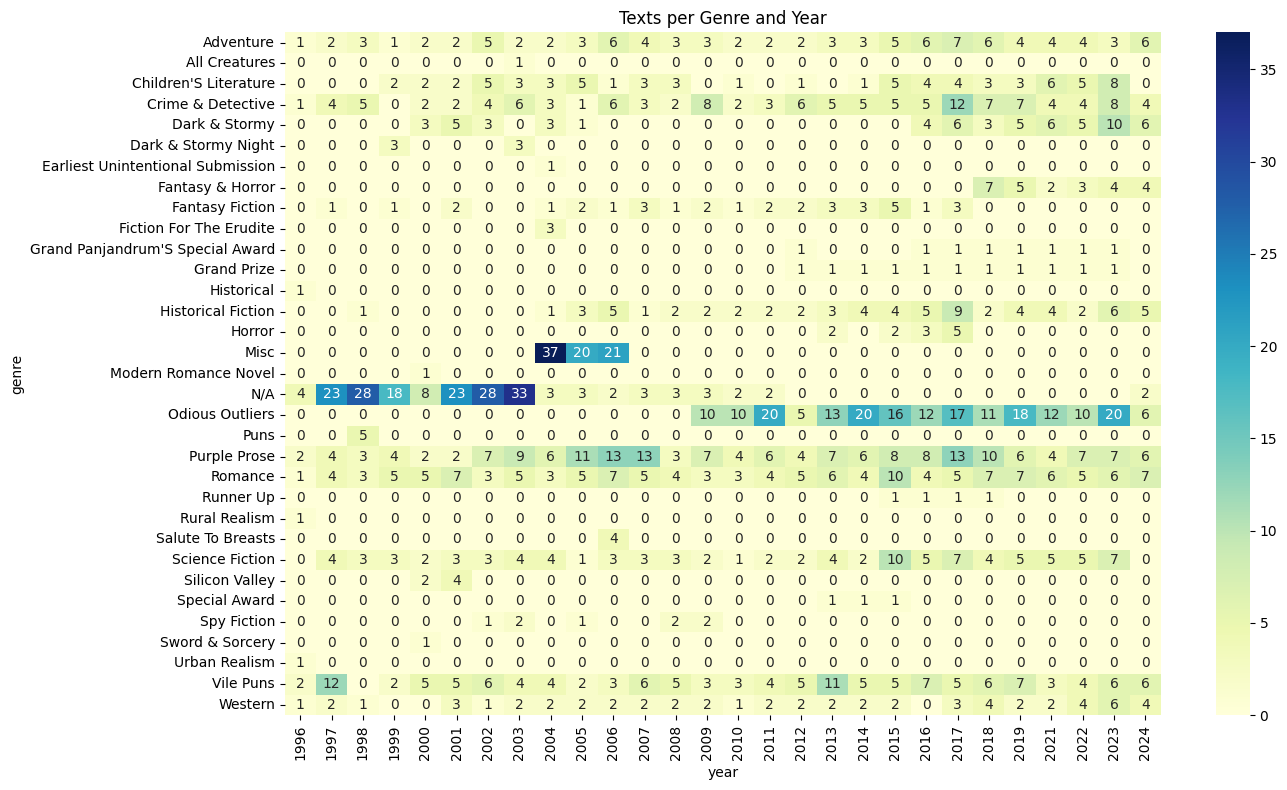

/tmp/ipython-input-2-2283452424.py:322: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=df, x='year', palette='Blues_d')


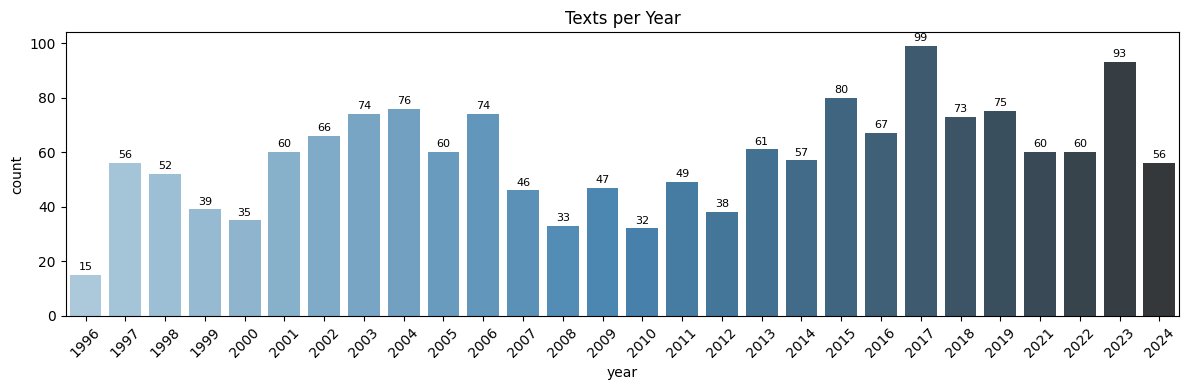

/tmp/ipython-input-2-2283452424.py:334: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=df, y='genre', order=genre_order, palette='Set3')


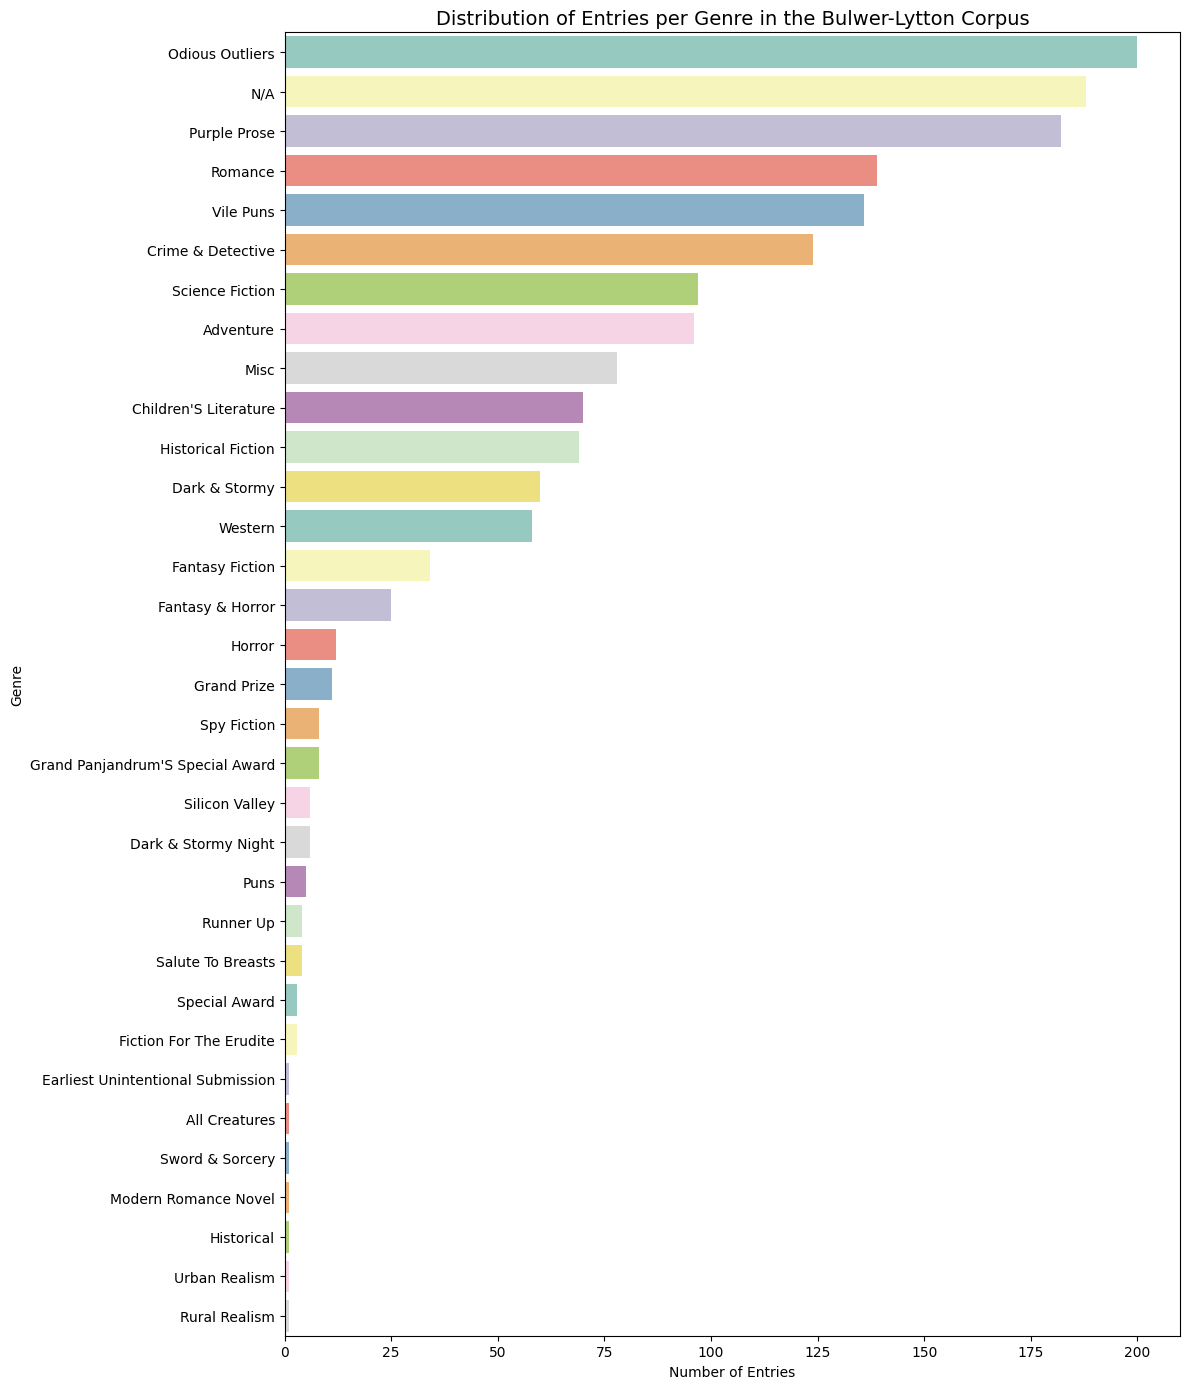

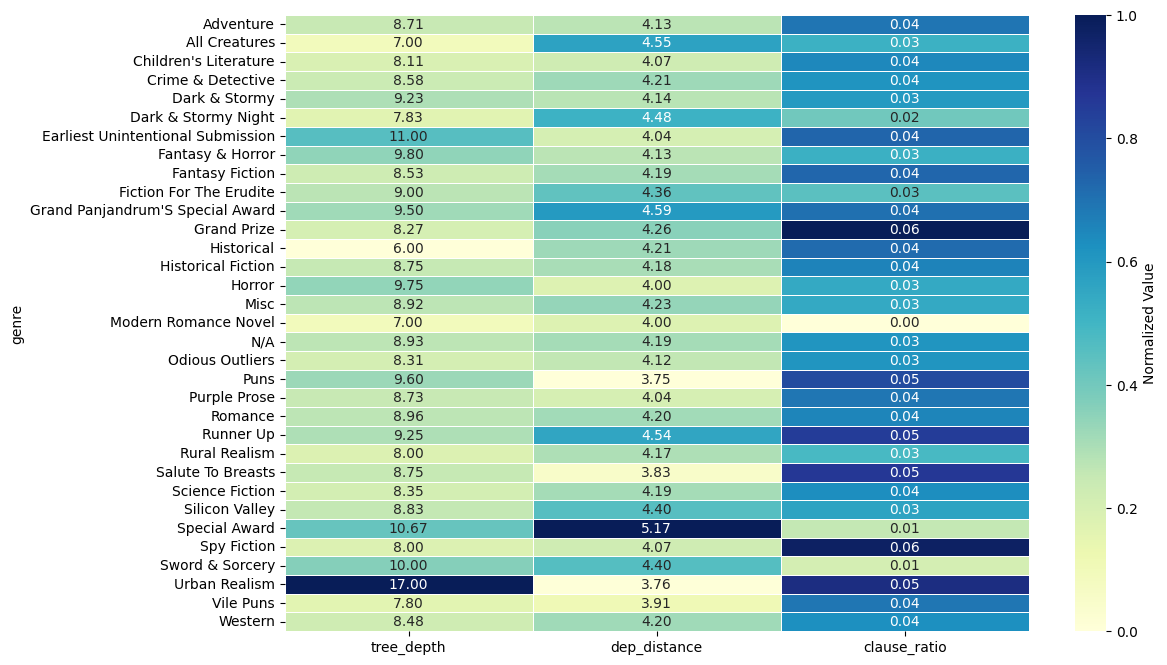

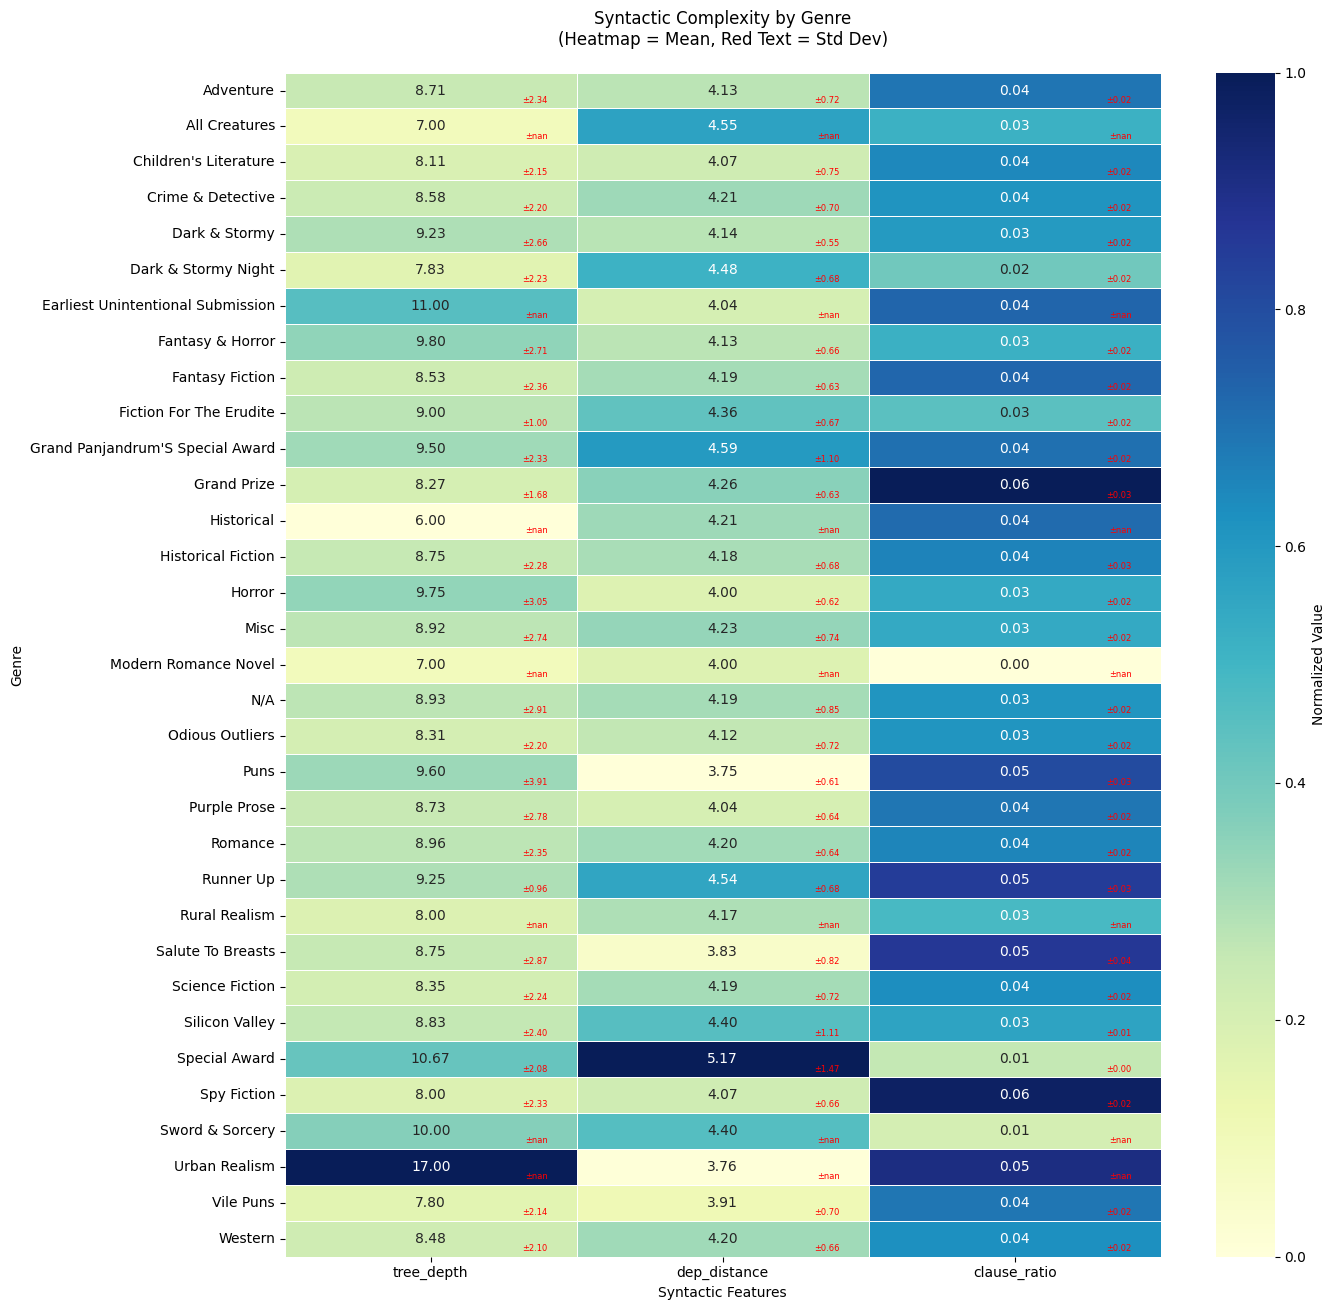

<Figure size 640x480 with 0 Axes>

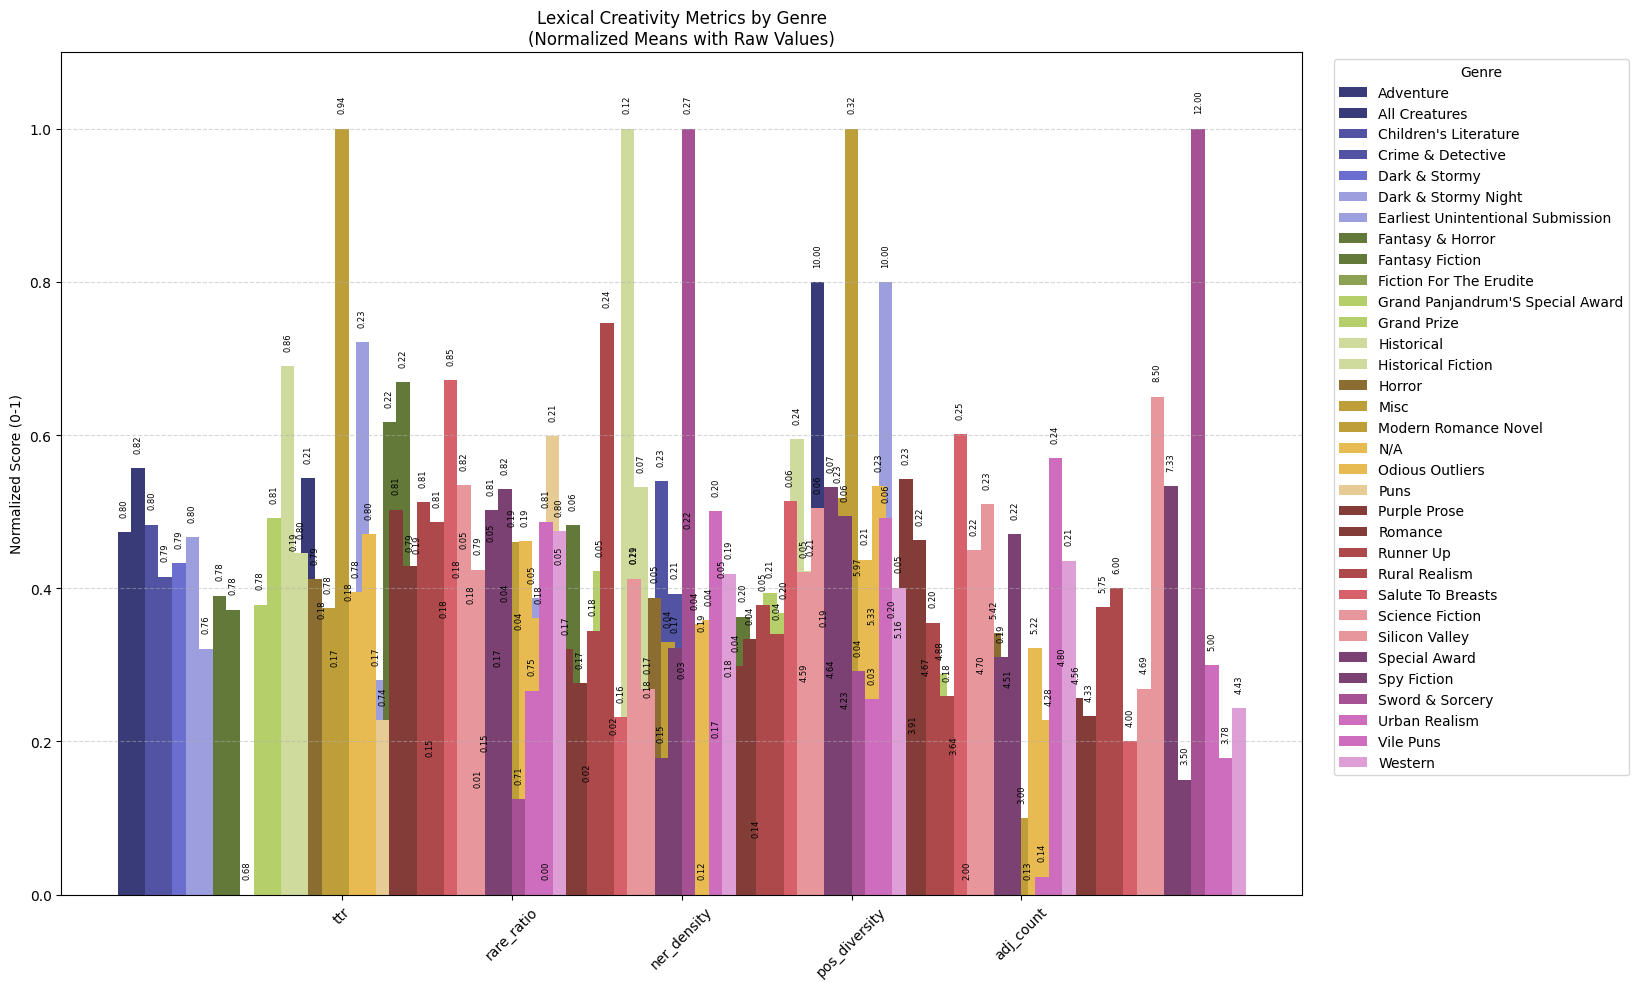

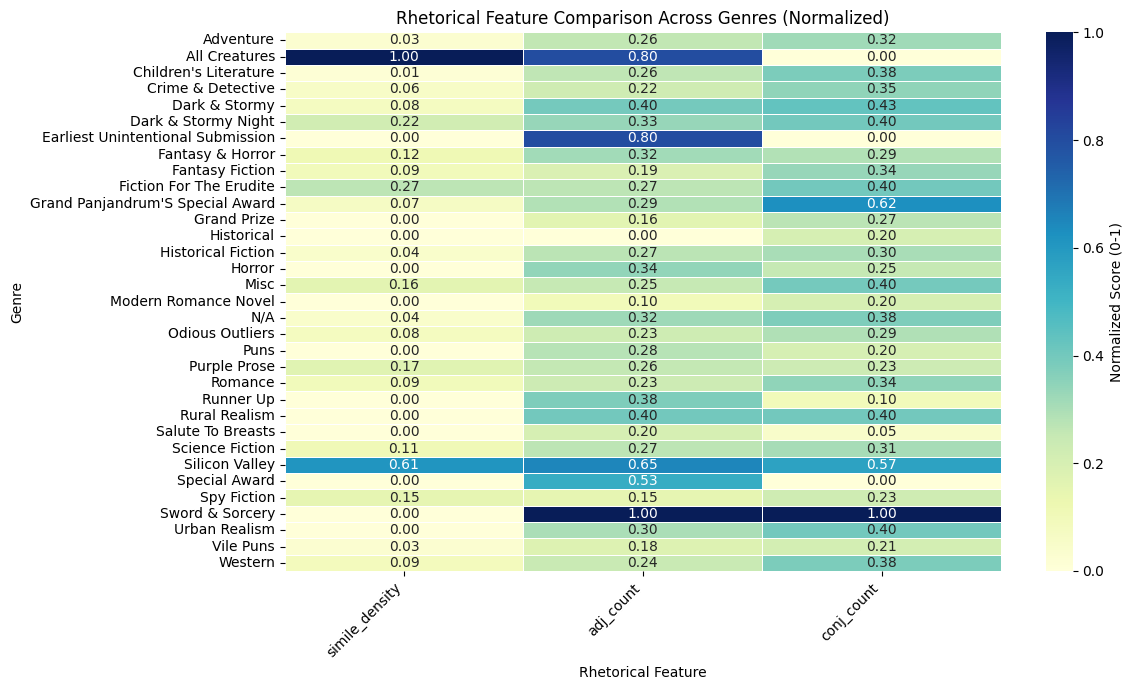

,feature,statistic,p_value,significant
7,ner_density,95.111830,3.525657e-08,True
6,rare_ratio,64.188207,6.263451e-04,True
10,adj_count,62.413547,1.020250e-03,True
8,pos_diversity,61.359942,1.356282e-03,True
9,simile_density,57.933849,3.331424e-03,True
0,tree_depth,57.740180,3.500490e-03,True
5,ttr,49.393438,2.548109e-02,True
4,avg_sent_len,47.648525,3.704735e-02,True
3,conj_count,47.603861,3.739630e-02,True
2,clause_ratio,46.125152,5.070314e-02,False



📊 Kruskal-Wallis H (tree_depth): H=57.74, p=3.50e-03



tree_depth           dep_distance            \
                                        mean       std         mean       std   
genre                                                                           
Adventure                           8.708333  2.343711     4.133709  0.716236   
All Creatures                       7.000000       NaN     4.552239       NaN   
Children's Literature               8.114286  2.150449     4.069825  0.748064   
Crime & Detective                   8.580645  2.197918     4.208480  0.703847   
Dark & Stormy                       9.233333  2.657683     4.141681  0.547693   
Dark & Stormy Night                 7.833333  2.228602     4.479427  0.677179   
Earliest Unintentional Submission  11.000000       NaN     4.042254       NaN   
Fantasy & Horror                    9.800000  2.708013     4.133700  0.660645   
Fantasy Fiction                     8.529412  2.364322     4.191113  0.632998   
Fiction For The Erudite             9.000000  1.000000     4.364336  0.666750   
Grand Panjandrum'S Special Award    9.500000  2.329929     4.594504  1.096092   
Grand Prize                         8.272727  1.678744     4.256479  0.631863   
Historical                          6.000000       NaN     4.208333       NaN   
Historical Fiction                  8.753623  2.284254     4.180660  0.684912   
Horror                              9.750000  3.048845     4.001348  0.624193   
Misc                                8.923077  2.738704     4.227843  0.742625   
Modern Romance Novel                7.000000       NaN     4.000000       NaN   
N/A                                 8.925532  2.905791     4.188216  0.849883   
Odious Outliers                     8.310000  2.204130     4.115122  0.719853   
Puns                                9.600000  3.911521     3.749332  0.609202   
Purple Prose                        8.730769  2.776985     4.036329  0.642326   
Romance                             8.956835  2.349439     4.196586  0.644844   
Runner Up                           9.250000  0.957427     4.540680  0.683114   
Rural Realism                       8.000000       NaN     4.169014       NaN   
Salute To Breasts                   8.750000  2.872281     3.825188  0.822252   
Science Fiction                     8.350515  2.240913     4.189552  0.718007   
Silicon Valley                      8.833333  2.401388     4.395512  1.110316   
Special Award                      10.666667  2.081666     5.166365  1.474682   
Spy Fiction                         8.000000  2.329929     4.069046  0.664125   
Sword & Sorcery                    10.000000       NaN     4.397590       NaN   
Urban Realism                      17.000000       NaN     3.757895       NaN   
Vile Puns                           7.801471  2.142411     3.906430  0.700666   
Western                             8.482759  2.096291     4.202193  0.656146   

                                  clause_ratio           conj_count            \
                                          mean       std       mean       std   
genre                                                                           
Adventure                             0.039622  0.021274   2.593750  2.269144   
All Creatures                         0.029412       NaN   1.000000       NaN   
Children's Literature                 0.036788  0.021278   2.900000  2.240277   
Crime & Detective                     0.035152  0.022219   2.733871  2.145553   
Dark & Stormy                         0.033910  0.019918   3.150000  1.990017   
Dark & Stormy Night                   0.022984  0.017169   3.000000  3.162278   
Earliest Unintentional Submission     0.041667       NaN   1.000000       NaN   
Fantasy & Horror                      0.029773  0.017451   2.440000  1.157584   
Fantasy Fiction                       0.041588  0.022704   2.676471  3.012304   
Fiction For The Erudite               0.025548  0.022529   3.000000  1.732051   
Grand Panjandrum'S Special Award      0.040171  0.020465   4.125

📉 Temporal test for rare_ratio: H=30.12, p=3.73e-05
📉 Temporal test for simile_density: H=6.71, p=3.49e-01
📉 Temporal test for avg_sent_len: H=83.83, p=5.77e-16


/tmp/ipython-input-3-658958271.py:44: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  temporal_stats = df.groupby("year_group")[temporal_features].agg(['mean', 'std'])
/tmp/ipython-input-3-658958271.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = [g[feature].dropna() for _, g in df.groupby("year_group") if not g[feature].isna().all()]
/tmp/ipython-input-3-658958271.py:54: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this wa

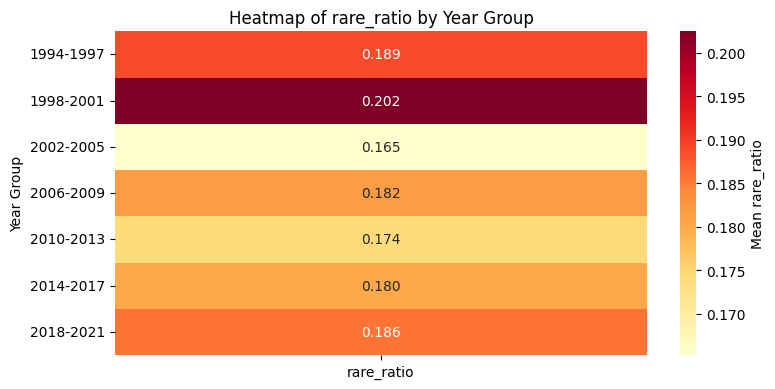

/tmp/ipython-input-3-658958271.py:67: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=mean_df, x="year_group", y=feature, palette="Blues_d")


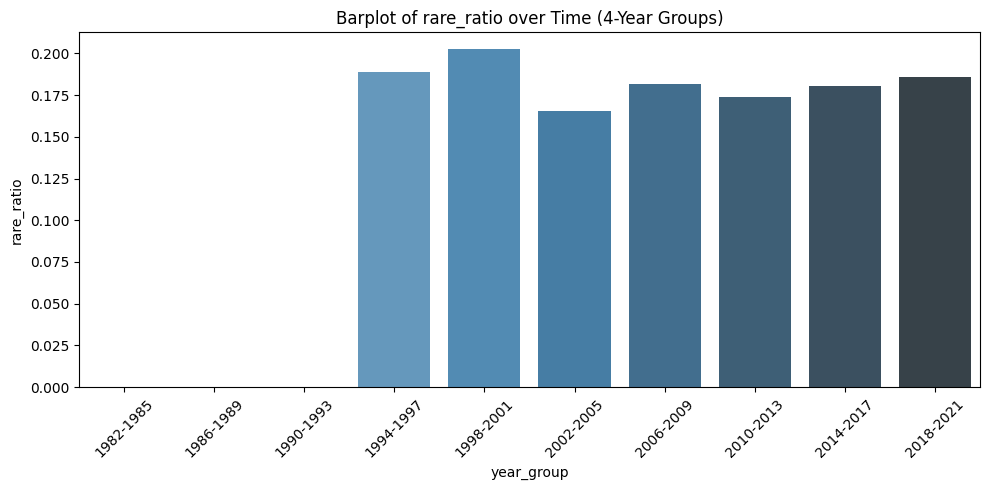

/tmp/ipython-input-3-658958271.py:54: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_df = df.groupby('year_group')[feature].mean().reset_index()
/tmp/ipython-input-3-658958271.py:55: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  mean_pivot = mean_df.pivot_table(index='year_group', values=feature)


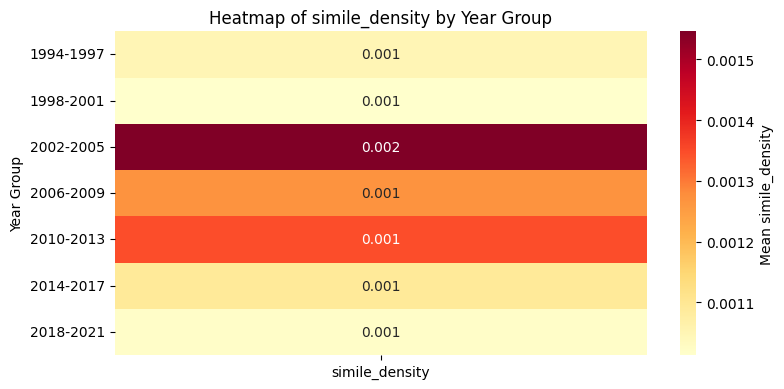

/tmp/ipython-input-3-658958271.py:67: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=mean_df, x="year_group", y=feature, palette="Blues_d")


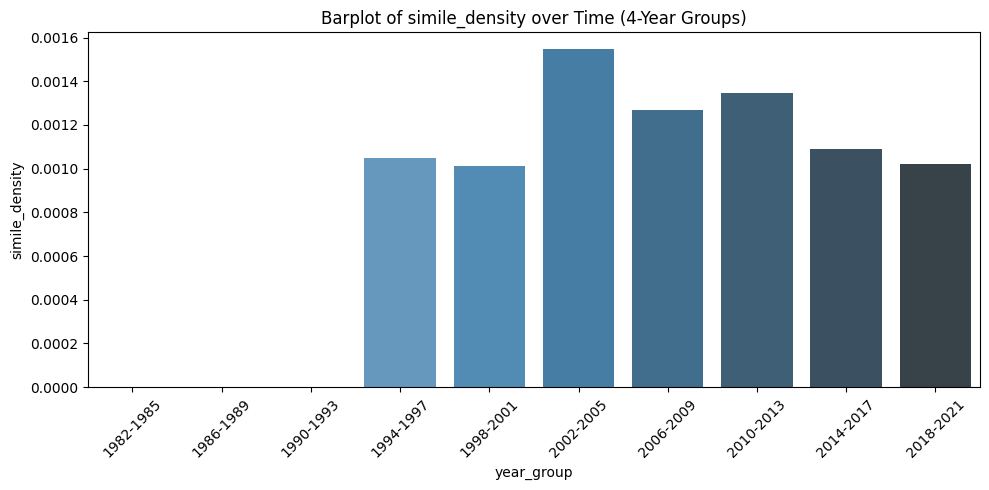

/tmp/ipython-input-3-658958271.py:54: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_df = df.groupby('year_group')[feature].mean().reset_index()
/tmp/ipython-input-3-658958271.py:55: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  mean_pivot = mean_df.pivot_table(index='year_group', values=feature)


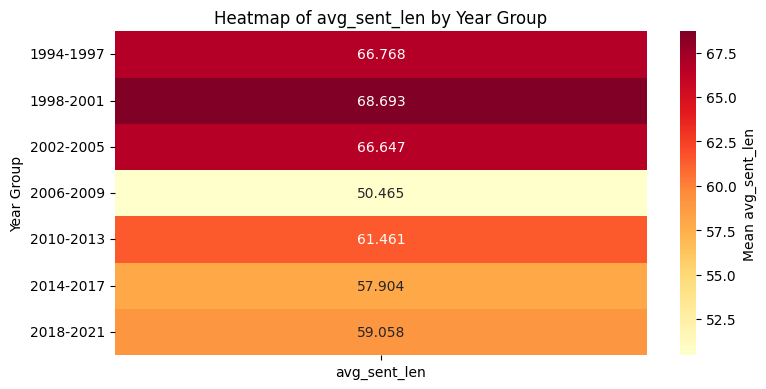

/tmp/ipython-input-3-658958271.py:67: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=mean_df, x="year_group", y=feature, palette="Blues_d")


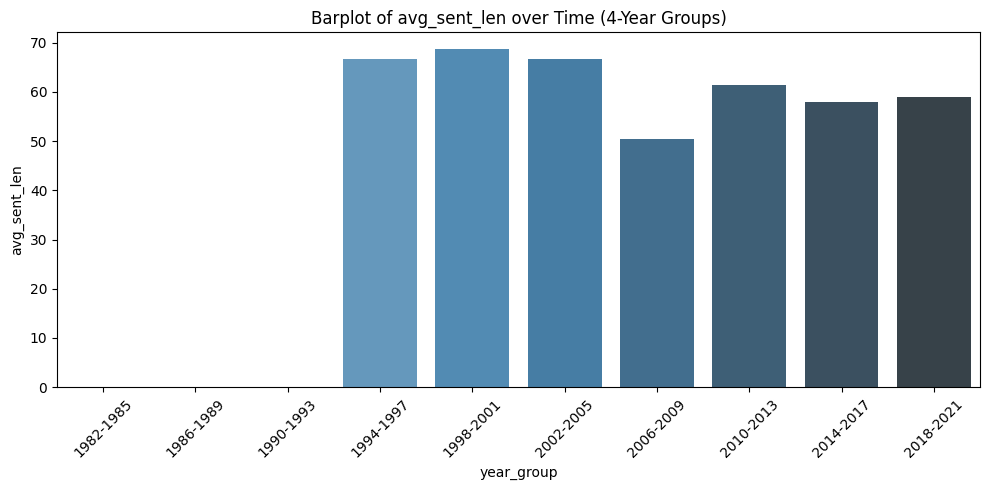

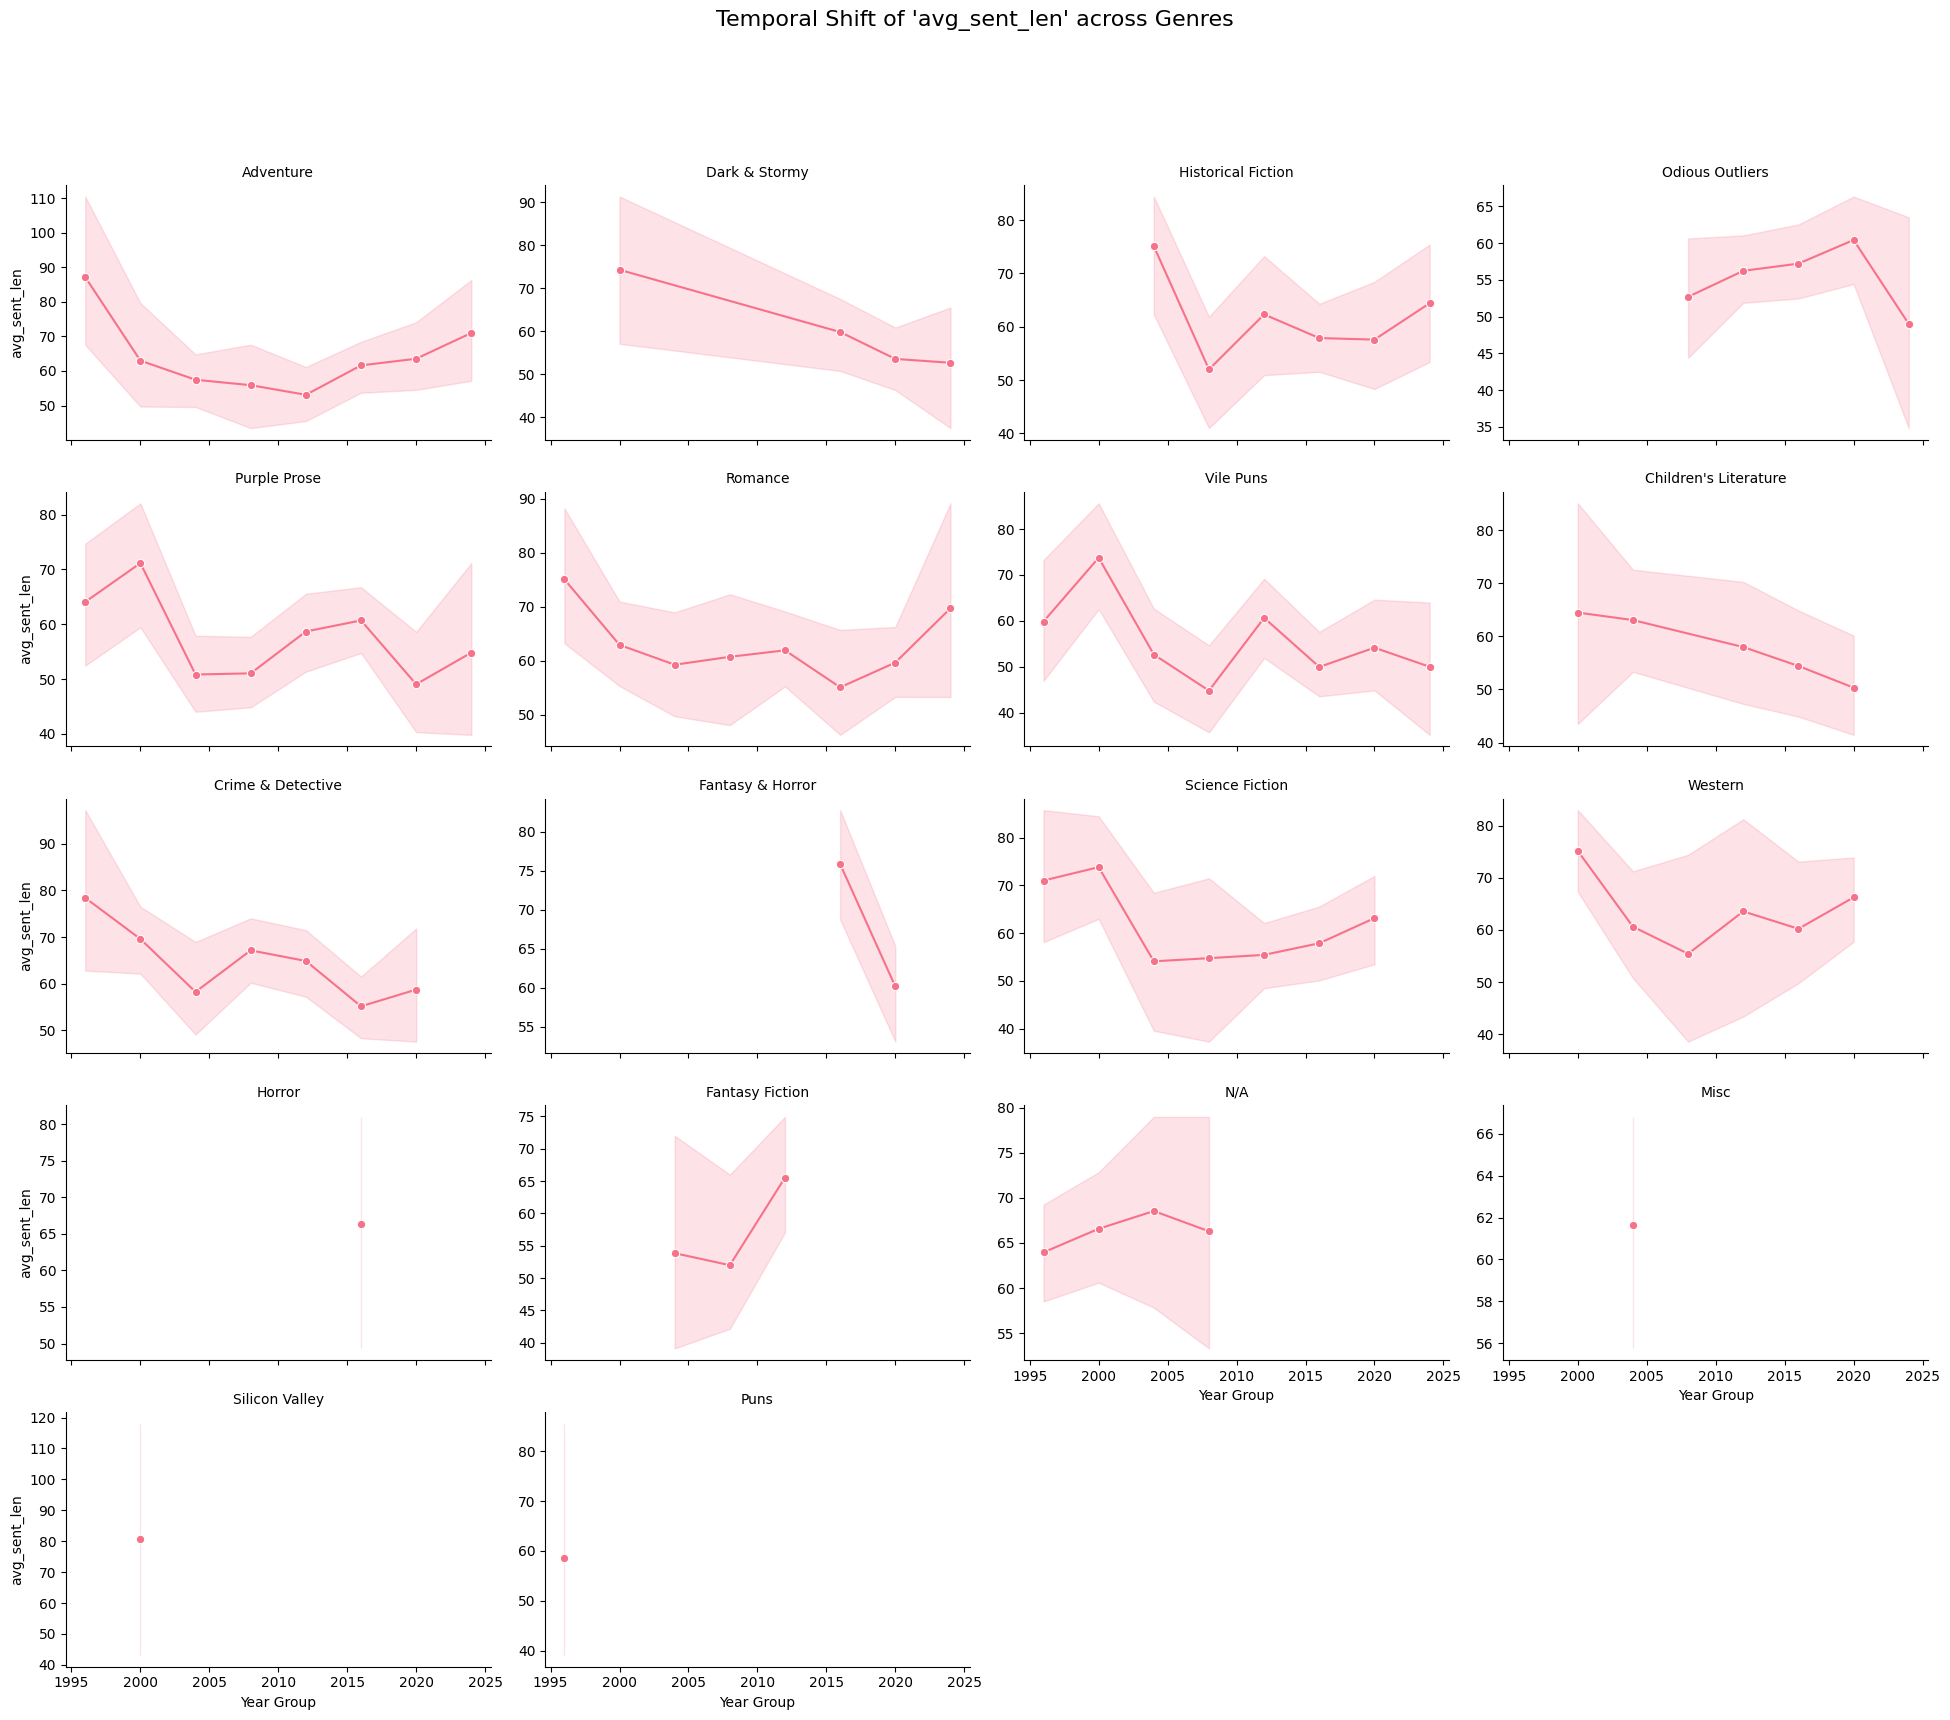

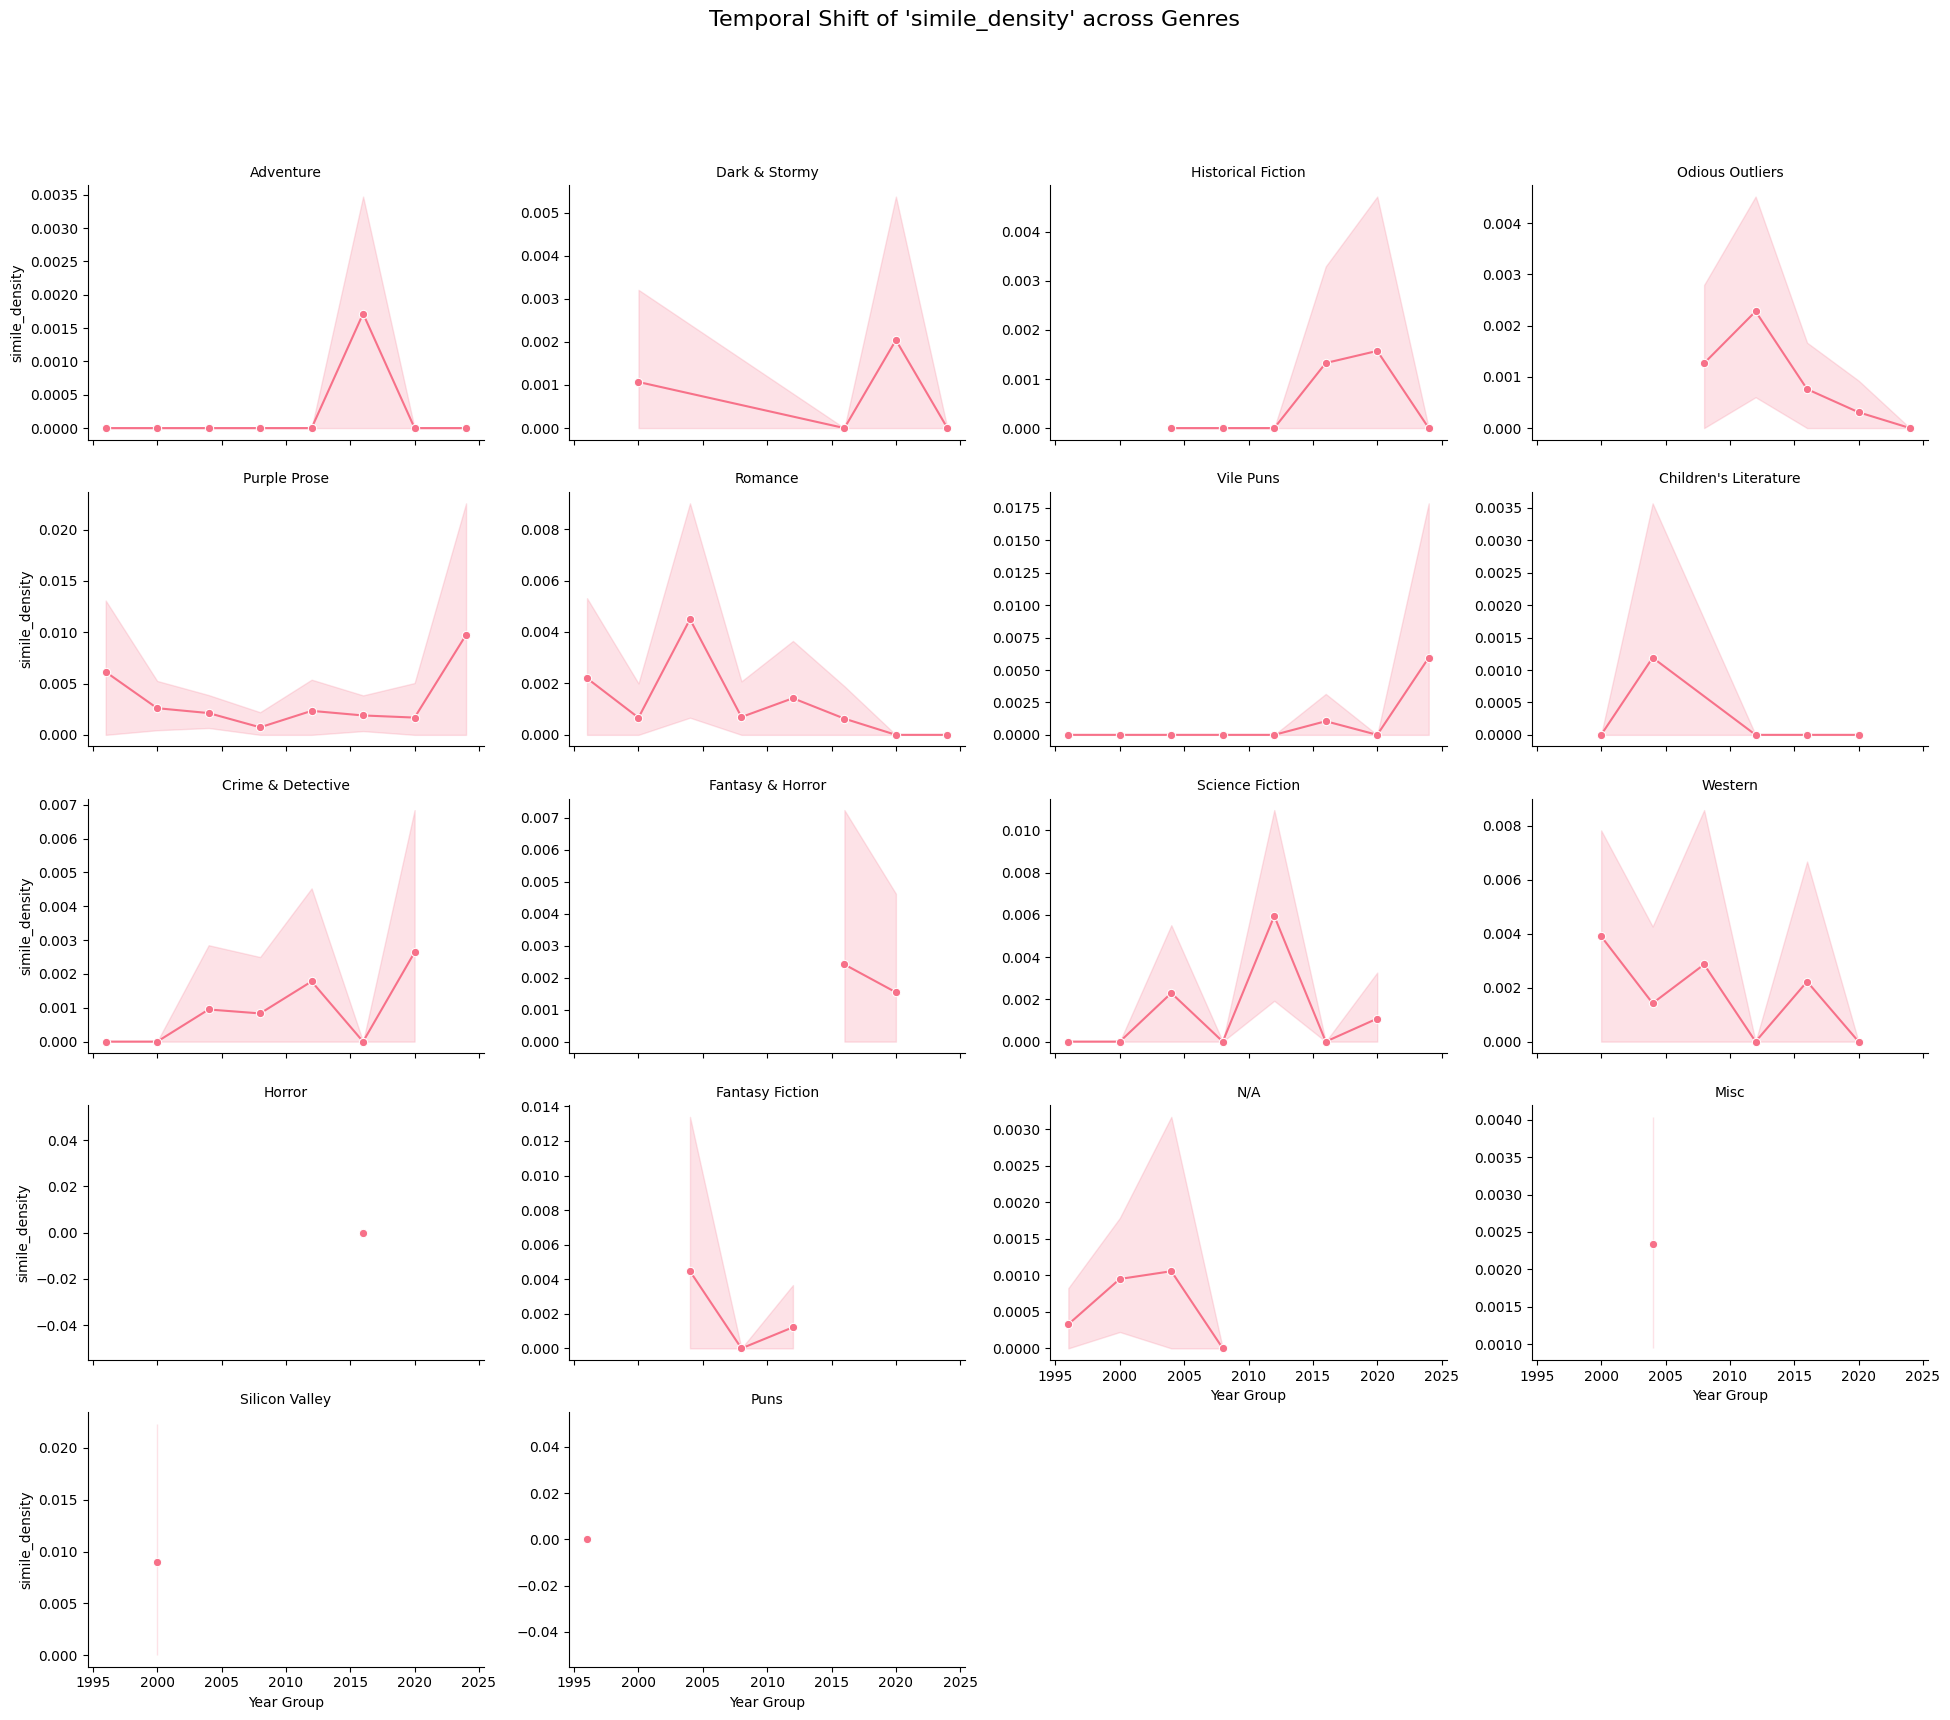

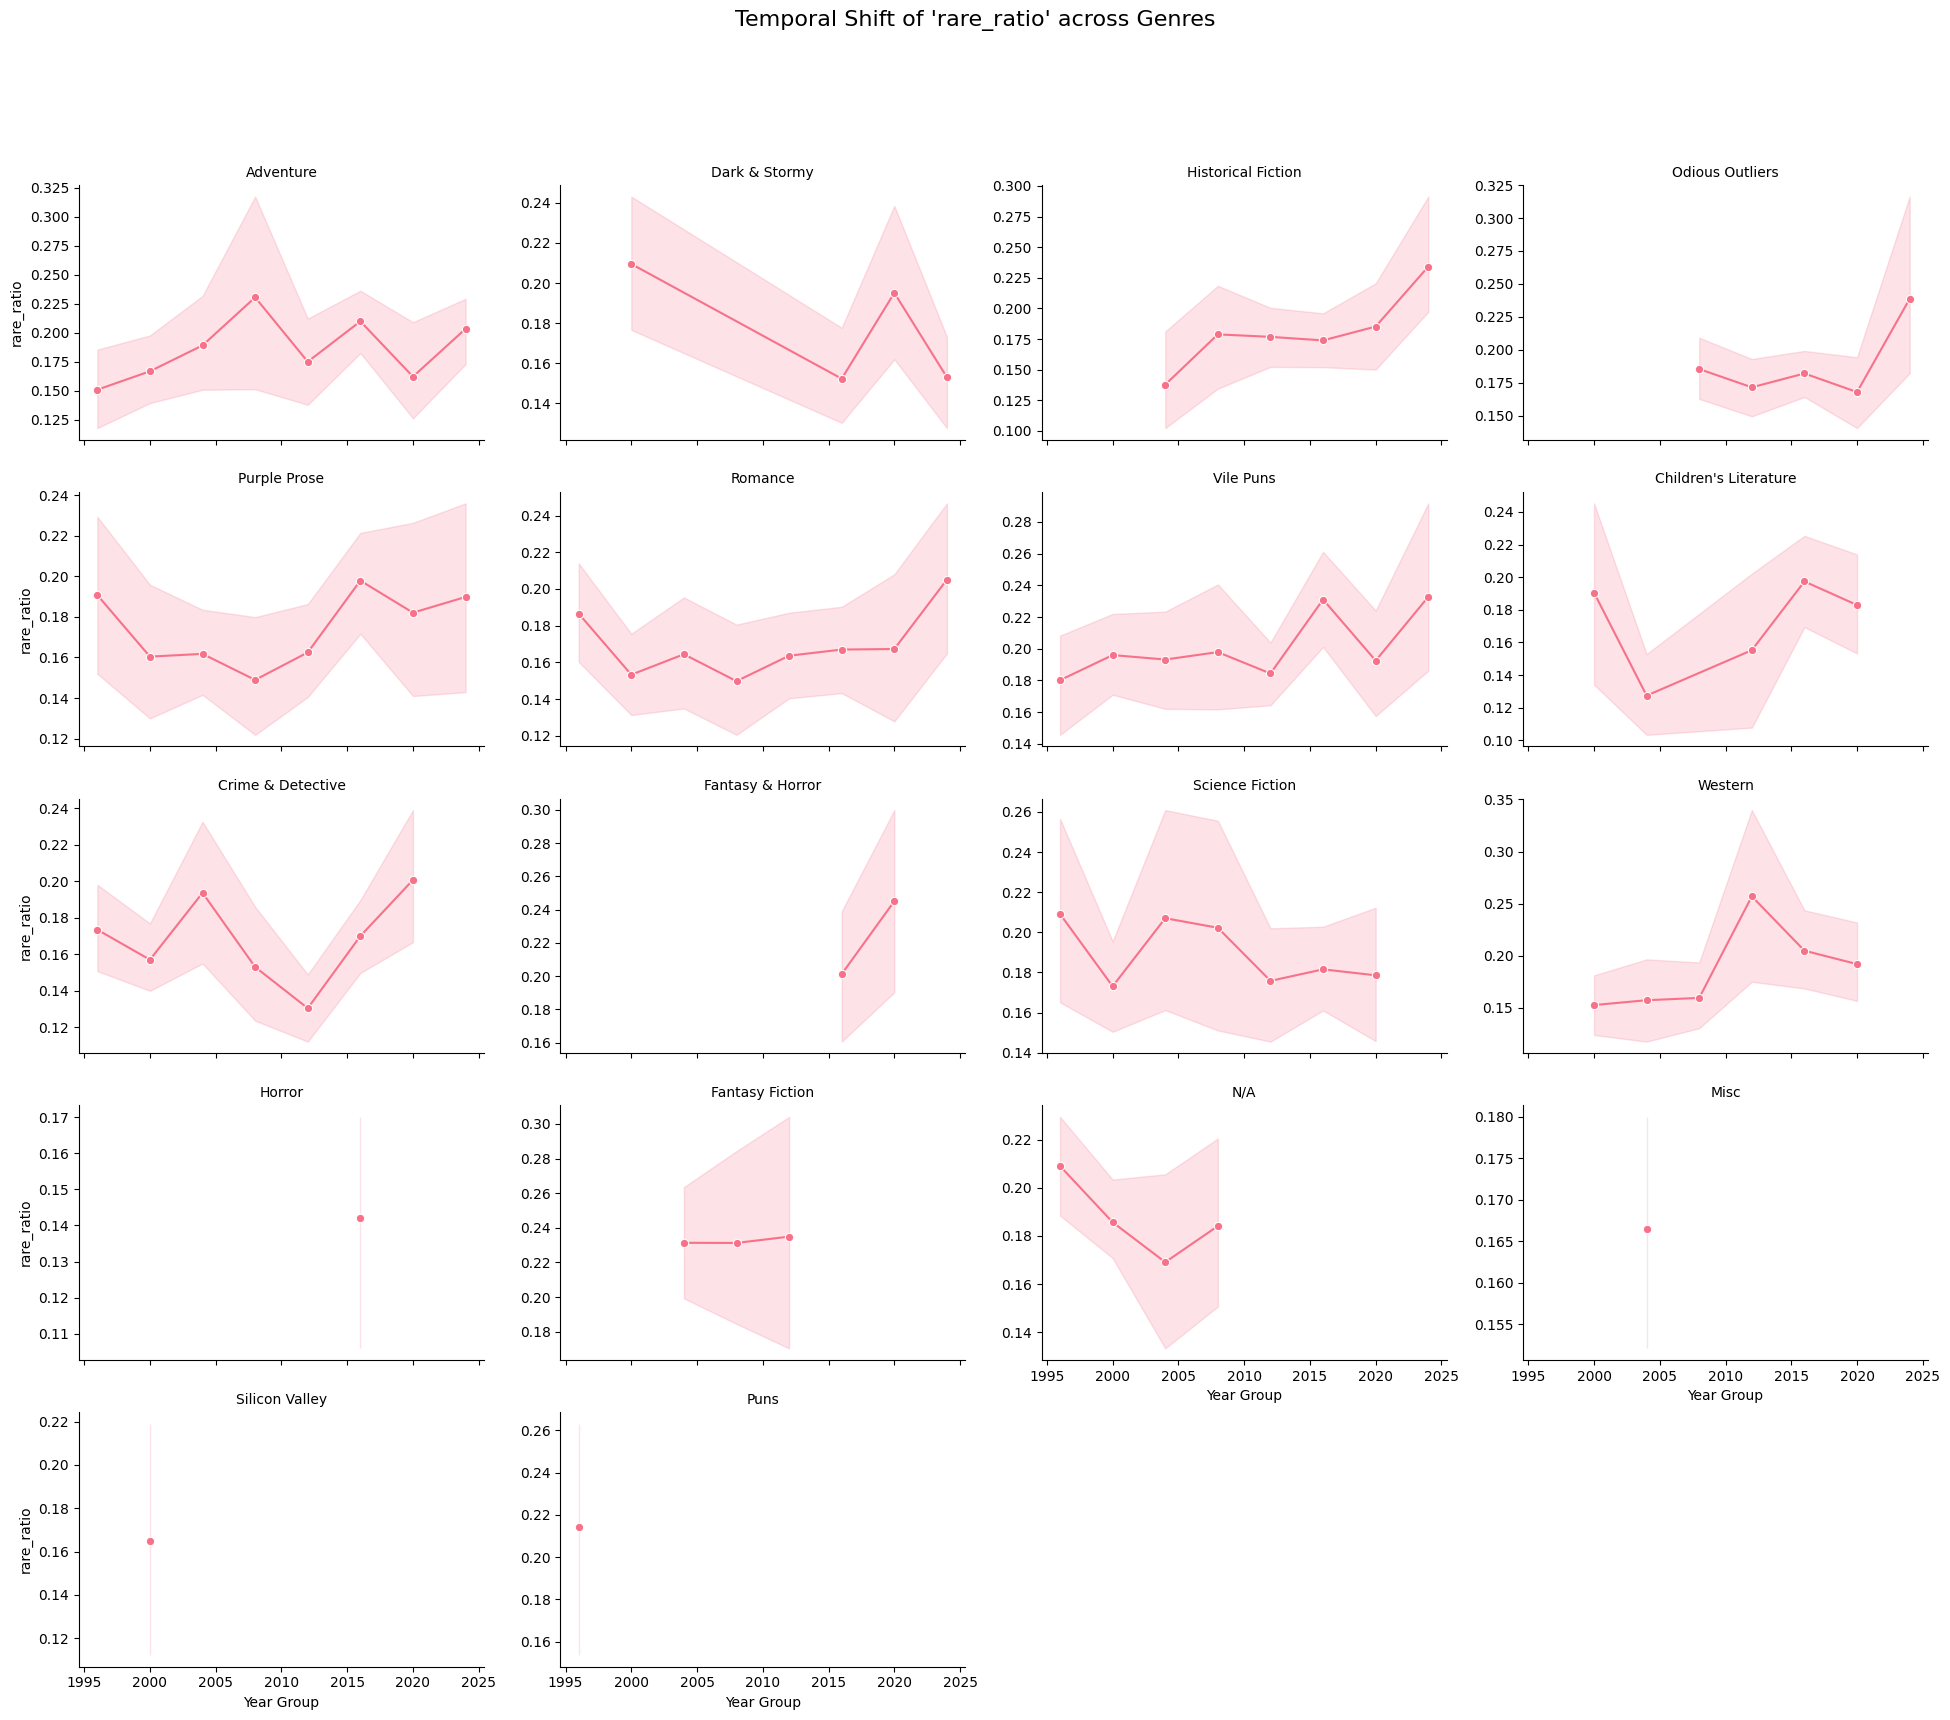

In [3]:
# ======================
# Main Execution
# ======================
if __name__ == "__main__":
    # initial
    analyzer = BulwerLyttonAnalyzer("/content/drive/MyDrive/stanza_humor_analysis/Bulwer_HumorText.tsv", gpu=True)

    # 1. data
    analyzer.df = analyzer._load_data()

    # 2. distribution
    analyzer.plot_distributions()

    # 3. feature
    analyzer._extract_features()

    # 4. visualize features
    analyzer.visualize_features()

    # 5. Kruskal-Wallis
    test_results = analyzer.run_statistical_tests()
    display(test_results)

    #6. Mean/Std by Genre
    feature_cols = [
        "tree_depth", "dep_distance", "clause_ratio", "conj_count", "avg_sent_len",
        "ttr", "rare_ratio", "ner_density", "pos_diversity", "simile_density", "adj_count"
    ]
    genre_stats = analyzer.df.groupby("genre")[feature_cols].agg(['mean', 'std'])
    print(f"\n📊 Kruskal-Wallis H (tree_depth): H={test_results[test_results.feature == 'tree_depth'].statistic.values[0]:.2f}, "
          f"p={test_results[test_results.feature == 'tree_depth'].p_value.values[0]:.2e}\n")
    display(genre_stats)

     # 7. Temporal Analysis (4-year groups)
    import numpy as np
    df = analyzer.df.copy()
    df['year'] = pd.to_numeric(df['year'], errors='coerce')
    df = df.dropna(subset=['year'])
    df['year'] = df['year'].astype(int)
    bins = list(range(1982, 2026, 4))
    labels = [f"{y}-{y+3}" for y in bins[:-1]]
    df['year_group'] = pd.cut(df['year'], bins=bins, labels=labels, right=False)
    temporal_features = ['rare_ratio', 'simile_density', 'avg_sent_len']
    temporal_stats = df.groupby("year_group")[temporal_features].agg(['mean', 'std'])

    from scipy.stats import kruskal
    for feature in temporal_features:
      groups = [g[feature].dropna() for _, g in df.groupby("year_group") if not g[feature].isna().all()]
      if len(groups) > 1:
          stat, p = kruskal(*groups)
          print(f"📉 Temporal test for {feature}: H={stat:.2f}, p={p:.2e}")

    for feature in temporal_features:
        mean_df = df.groupby('year_group')[feature].mean().reset_index()
        mean_pivot = mean_df.pivot_table(index='year_group', values=feature)

        # 🔹 Heatmap
        plt.figure(figsize=(8, 4))
        sns.heatmap(mean_pivot, annot=True, fmt=".3f", cmap="YlOrRd", cbar_kws={'label': f'Mean {feature}'})
        plt.title(f"Heatmap of {feature} by Year Group")
        plt.ylabel("Year Group")
        plt.tight_layout()
        plt.show()

        # 🔹 Barplot
        plt.figure(figsize=(10, 5))
        sns.barplot(data=mean_df, x="year_group", y=feature, palette="Blues_d")
        plt.title(f"Barplot of {feature} over Time (4-Year Groups)")
        plt.xticks(rotation=45)
        plt.ylabel(feature)
        plt.tight_layout()
        plt.show()

    # 8. Genre-Year FacetGrid Temporal Trend Lineplots

    # Prepare Data
    df = analyzer.df.copy()
    df = df.dropna(subset=["year", "genre"])
    df["year"] = df["year"].astype(int)
    df["year_group"] = (df["year"] // 4) * 4  # e.g., 1996 → 1996

    # Filter sparse genre-year combinations
    min_count = 5
    genre_year_counts = df.groupby(["genre", "year_group"]).size().reset_index(name="count")
    valid_combos = genre_year_counts[genre_year_counts["count"] >= min_count]
    df = df.merge(valid_combos[["genre", "year_group"]], on=["genre", "year_group"])

    # Select features to visualize
    features = ["avg_sent_len", "simile_density", "rare_ratio"]

    # FacetGrid plotting loop
    for feature in features:
        g = sns.FacetGrid(df, col="genre", col_wrap=4, sharey=False, height=3.5, aspect=1.4)
        g.map_dataframe(sns.lineplot, x="year_group", y=feature, marker="o")
        g.set_titles("{col_name}")
        g.set_axis_labels("Year Group", feature)
        g.fig.suptitle(f"Temporal Shift of '{feature}' across Genres", fontsize=16)
        g.fig.subplots_adjust(top=0.88)
        plt.show()

In [4]:
import re

def collect_all_similes(analyzer):
    simile_patterns = analyzer._simile_patterns  # Use original regex patterns from your class
    matched_results = []

    for idx, row in analyzer.df.iterrows():
        text = row["text"]
        genre = row.get("genre", "Unknown")
        year = row.get("year", "N/A")

        matches = []
        for pattern in simile_patterns:
            found = pattern.findall(text)
            if found:
                matches.extend(found)

        if matches:
            matched_results.append({
                "index": idx,
                "genre": genre,
                "year": year,
                "text": text,
                "similes": matches
            })

    return matched_results

# Run and print results
simile_matches = collect_all_similes(analyzer)
print(f"Total entries with similes detected: {len(simile_matches)}")

# Example: print first 30 matches (you can change this or remove the limit)
for i, entry in enumerate(simile_matches[:30]):
    print(f"\n Index {entry['index']} | Year: {entry['year']} | Genre: {entry['genre']}")
    for simile in entry['similes']:
        print(f" Simile: {simile}")
    print(f" Text preview: {entry['text'][:100]}...")

# Optional: save all results to a CSV file
import pandas as pd
simile_df = pd.DataFrame(simile_matches)
simile_df.to_csv("simile_matches.csv", index=False)

Total entries with similes detected: 145

 Index 19 | Year: 2024 | Genre: Fantasy & Horror
 Simile: as soon as he
 Text preview: Harry Potter was a happy eleven-year-old wizard who lived with two kind and supportive parents in Go...

 Index 36 | Year: 2024 | Genre: Purple Prose
 Simile: as salty as French
 Text preview: His burnt flesh sizzling like a burger on the grill, blood pouring from his wounds like an overshake...

 Index 37 | Year: 2024 | Genre: Purple Prose
 Simile: as thick as pea
 Text preview: Stepping outside just after dawn, Chef Billingsworth was pleased to discover that for once the morni...

 Index 51 | Year: 2024 | Genre: Vile Puns
 Simile: as slow as my
 Text preview: "My laddies may not be the fastest sugar cane harvesters," Fergus confessed, "but they're not as slo...

 Index 75 | Year: 2023 | Genre: Crime & Detective
 Simile: as nakedly unconvincing as Mick
 Text preview: Under the skewering stare of DI Jack ‘Robin’ Redbreast, the culprit’s wits scattered like a 